In [1]:
#%reset -f

import pandas as pd
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import itertools
import gurobipy as gp

from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D
from numpy import sqrt, sin, cos, pi
from numpy.linalg import inv
from numba import jit

plt.style.use('default')                                    # 使用默认风格
plt.rcParams['figure.facecolor'] = 'white'                  # 将图形的背景颜色设置为白色
plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'       # 字体确认
plt.rcParams['font.size'] = 12                              # 字体大小
plt.rcParams['axes.unicode_minus'] = False                  # 正常显示负号
%matplotlib inline
#matplotlib.use('TkAgg')

NodesDf1 = pd.read_csv('附件/附件1.csv',encoding='GB18030')
TractorInfo = pd.read_csv('附件/附件2.csv',encoding='GB18030')
connectInfo = pd.read_csv('附件/附件3.csv',encoding='GB18030')

## 函数
def dist(p1, p2):
    # 提取点的坐标
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

def drawPic(NodesList):
    plt.figure()
    ax1 = plt.axes(projection='3d')
    ax1.set_axis_off()
    plt.tight_layout()
    ax1.scatter(NodesList.iloc[:,1],NodesList.iloc[:,2],NodesList.iloc[:,3], marker = '.',s = 0.3,edgecolors = 'black',facecolors = 'black')
    ax1.view_init(elev=30, azim=43)
    # 进行坐标轴缩放，使得望远镜看起来更合理
    plt.gca().set_box_aspect((1, 1, 0.4))
    
    # 三个箭头的起点
    x = np.array([0, 0, 0])
    y = np.array([0, 0, 0])
    z = np.array([0, 0, 0])

    # 箭头的方向
    arrlen = 10
    u = np.array([10, 0, 0])  # X轴箭头
    v = np.array([0, 10, 0])  # Y轴箭头
    w = np.array([0, 0, 10])  # Z轴箭头

    # 绘制箭头
    ax1.quiver(x, y, z, u, v, w, length=arrlen, normalize=False, color='black')
    # 箭头文字
    # 在箭头终点添加标注文字
    ax1.text(110, 0, 0, 'X', color='black', fontsize=12, ha='center', va='center')
    ax1.text(0, 110, 0, 'Y', color='black', fontsize=12, ha='center', va='center')
    ax1.text(0, 0, 110, 'Z', color='black', fontsize=12, ha='center', va='center')

    # 散点之间连线
    node_dict = {}                  # 建立节点对应序号字典

    nodes = NodesList.iloc[:,0]
    for ind,rows in NodesList.iterrows():
        key,x,y,z = rows
        node_dict[key] = (x,y,z)

    for ind, rows in connectInfo.iterrows():
        for (x,y) in list(itertools.combinations(rows,2)):
            X1 = node_dict[x]
            X2 = node_dict[y]
            ax1.plot([X1[0], X2[0]], [X1[1], X2[1]], [X1[2], X2[2]], color='blue',linewidth = 0.2)

    plt.savefig('fast望远镜.png',format = 'png',dpi=400)

In [2]:
## 第一问：三分求解
NodesDf2 = pd.DataFrame(np.zeros((NodesDf1.shape[0], NodesDf1.shape[1] - 1)),
                        columns=['rho', 'phi', 'theta'])
for ind, rows in NodesDf1.iterrows():
    key, x, y, z = rows
    rho = (x**2 + y**2 + z**2)**0.5
    if (x**2 + y**2)**0.5 == 0:
        phi = 0
    else:
        phi = np.arccos(x / (x**2 + y**2)**0.5)
    theta = np.arcsin(z / (x**2 + y**2 + z**2)**0.5)
    NodesDf2.iloc[ind] = [rho, phi, theta]

the0 = -np.arccos(150 / 300.4)
WorkingNodes = NodesDf2[NodesDf2['theta'] <= the0]


def dis(the, c):
    p = 2 * (c - 160.4136)
    if np.abs(the + np.pi / 2) < 1e-3:          #垂直情况不能使用通式
        d = (c - 300.4)
    else:
        d = ((2 * p * sin(the) +
            (4 * p * p * sin(the) * sin(the) + 8 * p * c * cos(the) * cos(the))**0.5) / 
            (2 * cos(the) * cos(the)) - 300.4)
    return d

def Q1Loss(c):
    loss = 0
    for ind, rows in WorkingNodes.iterrows():
        the = rows[2]
        loss += dis(the, c)**2
    return loss / WorkingNodes.shape[0]

## 使用三分算法求解

l = 295
r = 305
eps = 1e-6

while r - l > eps:
    mid1 = l + (r - l) / 3
    mid2 = r - (r - l) / 3
    if Q1Loss(mid1) < Q1Loss(mid2):
        r = mid2
    else:
        l = mid1
        
q1ans = (l + r) / 2
print([Q1Loss((l + r) / 2), q1ans])

## 出图准备

l = 295
r = 305
dis_sum = []
for c in np.arange(l,r,0.1):
    dis_sum.append(Q1Loss(c))
    
q1sse = []
for ind, rows in WorkingNodes.iterrows():
    the = rows[2]
    q1sse.append(dis(the, q1ans))
q1sse.sort()

[0.039109272390945256, 300.8443642461365]


In [ ]:
## 第一问：结果输出

# 表：验证促动器上端点、主索节点、圆心是否共线

# 计算两个向量
vector1 = (NodesDf1.x - TractorInfo.lx, NodesDf1.y - TractorInfo.ly, NodesDf1.z - TractorInfo.lz)
vector2 = (0 - NodesDf1.x, 0 - NodesDf1.y, 0 - NodesDf1.z)
# 向量夹角计算
dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1] + vector1[2] * vector2[2]
magnitude_vector1 = sqrt(vector1[0]**2 + vector1[1]**2 + vector1[2]**2)
magnitude_vector2 = sqrt(vector2[0]**2 + vector2[1]**2 + vector2[2]**2)
theta = np.arccos(dot_product / (magnitude_vector1 * magnitude_vector2))
deg = theta * 180 / pi

arg = pd.DataFrame(data=[NodesDf1.iloc[np.where(deg > 5)[0],0].values,deg.values[np.where(deg>=1)]], index=['point','deg'])
arg.to_excel('检查是否共线.xlsx')

# 绘制fast图(时间较长)
# drawPic(NodesDf1)

# 创建折线图
plt.plot(np.arange(l,r,0.1),dis_sum, linestyle='-',color='orange',linewidth=2)
plt.scatter(q1ans,min(dis_sum), marker='*', edgecolors='red', facecolors='none', s=70)
# 添加标题和标签
plt.xlabel('优化变量')
plt.ylabel('目标值')
plt.legend(['径向距离和','极小值点'])
plt.savefig('./imgs/q1遍历折线图.png',dpi=300)

## 结果检验：检验个点的径向距离
plt.figure(figsize=(8, 6))
plt.bar(np.arange(0, WorkingNodes.shape[0]), q1sse, color='b',width=0.6)
plt.scatter(np.arange(0, WorkingNodes.shape[0]-1),q1sse[:-1],marker='.',edgecolors='black', facecolors='none',s=5)
plt.xlabel('节点索引')
plt.ylabel('径向距离')
plt.grid(True)
plt.savefig('./imgs/q1各点径向距离.png',dpi=300)



In [2]:
## 第二问：数据处理

## 确认变换矩阵，求出旋转后抛物面顶点坐标
alpha = 36.795 * np.pi / 180
beta = 78.169 * np.pi / 180

R = np.array([[cos(alpha) * sin(beta),
               sin(alpha) * sin(beta), -cos(beta)],
              [-sin(alpha), cos(alpha), 0],
              [cos(alpha) * cos(beta),
               sin(alpha) * cos(beta),
               sin(beta)]])

## 对所有的主索节点和促动器进行坐标变换

# 主索节点
tranNodes = pd.DataFrame(np.zeros((NodesDf1.shape)),
                            columns=['NodeNames', 'x', 'y', 'z'])
tranNodes.iloc[:, 0] = NodesDf1.iloc[:, 0]
tranNodes.iloc[:, 1:] = np.dot(NodesDf1.iloc[:, 1:], R.T)     # 这里只能写成 X @ R.T 它等价于R @ X


# 促动器
tranTractors = pd.DataFrame(np.zeros((TractorInfo.shape)),
                            columns=['NodeNames', 'lx', 'ly', 'lz','ux','uy','uz'])
tranTractors.iloc[:, 0] = TractorInfo.iloc[:, 0]                       
tranTractors.iloc[:, 1:4] = np.dot(TractorInfo.iloc[:, 1:4], R.T)      # 对促动器下端点进行变换
tranTractors.iloc[:, 4:7] = np.dot(TractorInfo.iloc[:, 4:7], R.T)      # 对促动器上端点进行变换

## 筛选出工作区域内的主索节点以及促动器

the0 = -np.arccos(150 / 300.4)
tranWorkingNodes = tranNodes[np.arcsin(tranNodes['z'] / (tranNodes['x']**2 + tranNodes['y']**2 + tranNodes['z']**2)**0.5) <= the0]
tranWorkingTractors = tranTractors.iloc[tranWorkingNodes.index,:]

## 行号重排

tranWorkingNodes = tranWorkingNodes.reset_index(drop = 1)
tranWorkingTractors = tranWorkingTractors.reset_index(drop = 1)

## 计算lc ls

Lc = np.sqrt((tranWorkingTractors['ux'] - tranWorkingTractors['lx']) ** 2 + 
                (tranWorkingTractors['uy'] - tranWorkingTractors['ly']) ** 2 + 
                (tranWorkingTractors['uz'] - tranWorkingTractors['lz']) ** 2)

Ls = np.sqrt((tranWorkingNodes['x'] - tranWorkingTractors['ux']) ** 2 + 
                (tranWorkingNodes['y'] - tranWorkingTractors['uy']) ** 2 + 
                (tranWorkingNodes['z'] - tranWorkingTractors['uz']) ** 2)

## 计算基态工作区域内主索节点对应抛物面上的点
# 定义变换函数
def transform1(row):
    c1 = 561.7228
    c2 = 300.8443
    x, y, z = row[['x','y','z']]
    p = (c1 * x * z + x * ((c1 ** 2 * z ** 2 + 4 * c1 * c2 * (x ** 2 + y ** 2)) ** 0.5)) / (2 * (x ** 2 + y ** 2))
    q = (c1 * y * z + y * ((c1 ** 2 * z ** 2 + 4 * c1 * c2 * (x ** 2 + y ** 2)) ** 0.5)) / (2 * (x ** 2 + y ** 2))
    r = (c1 * z ** 2 + z * ((c1 ** 2 * z ** 2 + 4 * c1 * c2 * (x ** 2 + y ** 2)) ** 0.5)) / (2 * (x ** 2 + y ** 2))
    return pd.Series({'p': p, 'q': q, 'r': r})

tranWorkingNodes[['p', 'q', 'r']] = tranWorkingNodes.apply(transform1, axis=1)

## 验证B66号主索节点在坐标变换前的下拉杆长度是否为：8.51507819400385

pos = np.where(NodesDf1.iloc[:,0] == 'B66')
testlen = np.sqrt((TractorInfo['ux'] - NodesDf1['x']) ** 2 + 
                (TractorInfo['uy'] - NodesDf1['y']) ** 2 + 
                (TractorInfo['uz'] - NodesDf1['z']) ** 2)

#######################

# 使用tupledict可以提高检索速度
node_dict = gp.tupledict()                                  # 建立节点对应坐标字典
workingEdge_dict = gp.tupledict()                           # 工作区域内主索节点连接情况
working_node_names = set(tranWorkingNodes['NodeNames'])     # 工作区域内的点集
node_row_dict = {}                                          # 工作区域内点集对应的行号

for i, node_name in enumerate(tranWorkingNodes['NodeNames']):
    node_row_dict[node_name] = i
    
for ind,rows in NodesDf1.iterrows():
    key,x,y,z = rows
    node_dict[key] = (x,y,z)
    
for ind, rows in connectInfo.iterrows():
    for (x,y) in list(itertools.combinations(rows,2)):              # 三个点取两个
        if x in working_node_names and y in working_node_names:     
            # 准确来说这里应该使用or而不是and，因为边界的主索也应该满足相对长度变化的限制，但是这样子太麻烦了，可以使用假设大法
            x_row = node_row_dict.get(x)
            y_row = node_row_dict.get(y)
            # 对行标进行排序，避免重复
            if x_row > y_row :
                x_row, y_row = y_row, x_row
            workingEdge_dict[(x_row, y_row)] = dist(node_dict[x],node_dict[y])


Nodenums = len(tranWorkingNodes)
Edgenums = len(workingEdge_dict)
c1 = 561.7228
c2 = 300.8443
k1 = 1 / c1
k2 = -c2
R0 = 300.4

# 导出
merged_df = pd.merge(tranWorkingNodes,tranWorkingTractors,on='NodeNames')
merged_df.to_excel('第二问促动器与主索节点信息.xlsx', index=False)
merged_df.iloc[:,1:].to_csv('第二问促动器与主索节点信息.csv', index=False,header=False)

table_data = [(x, y, value) for (x, y), value in workingEdge_dict.items()]
df = pd.DataFrame(table_data, columns=['First Element', 'Second Element', 'Value'])
workingEdge_df = pd.DataFrame(table_data, columns=['node1', 'node2', 'len'])
workingEdge_df.to_excel('第二问工作区内主索长度.xlsx', index=False)
workingEdge_df.to_csv('第二问工作区内主索长度.csv', index=False,header=False)

In [ ]:
## 第二问：事前内容输出

testlen.values[pos]
print('旋转后的抛物面顶点坐标为：', [0,0,-300.8443] @ np.linalg.inv(R.T))
print(f"工作区域内主索节点有{Nodenums}个，工作区域内的主索一共有{Edgenums}条")
plt.plot(Lc,linewidth=0.7,color='#DAA21C')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.xlabel('主索节点编号')
plt.ylabel('促动器长度')
plt.savefig('./imgs/q2促动器长度.png',dpi=300)
plt.figure()
plt.plot(Ls,linewidth=0.7,color='#002876')
plt.ylabel('下拉索长度')
plt.xlabel('主索节点编号')
plt.savefig('./imgs/q2下拉索长度.png',dpi=300)

plt.figure()
plt.axis('equal')
plt.scatter(tranNodes.iloc[:,1],tranNodes.iloc[:,2], marker = '.',s = 5,edgecolors = 'green',facecolors = 'white')
plt.scatter(tranWorkingNodes.iloc[:,1],tranWorkingNodes.iloc[:,2], marker = '*',s = 7,edgecolors = 'blue',facecolors = 'blue')
plt.savefig('./imgs/q2工作区域.png',dpi=500)

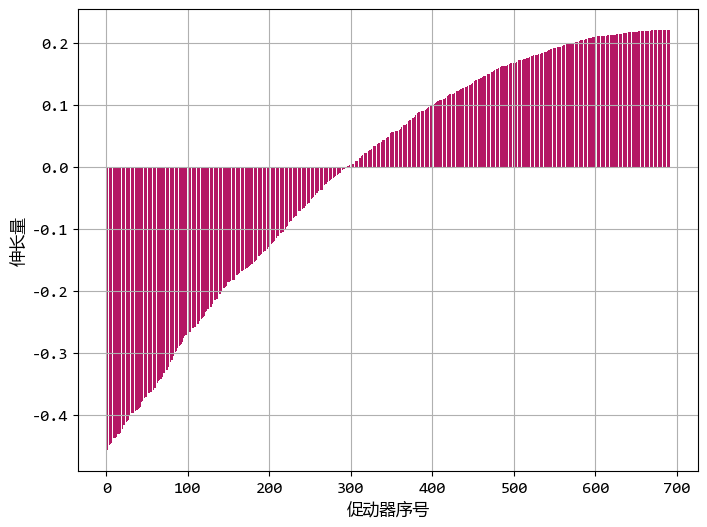

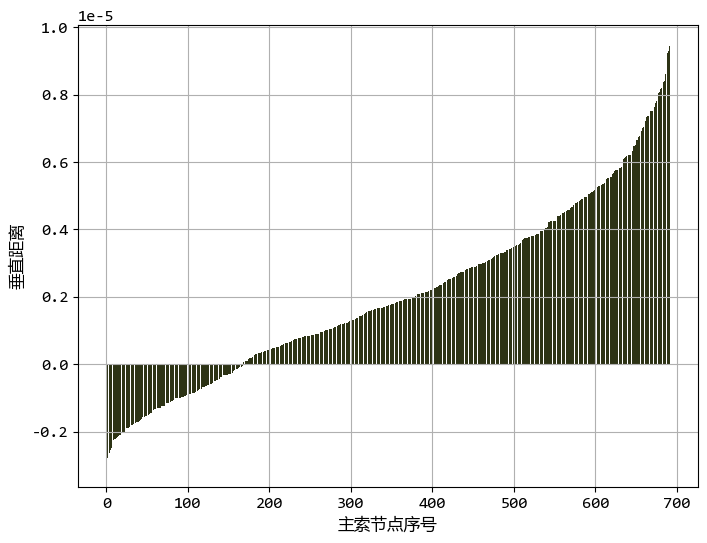

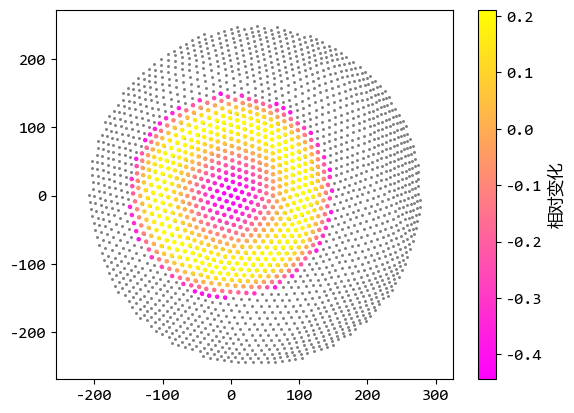

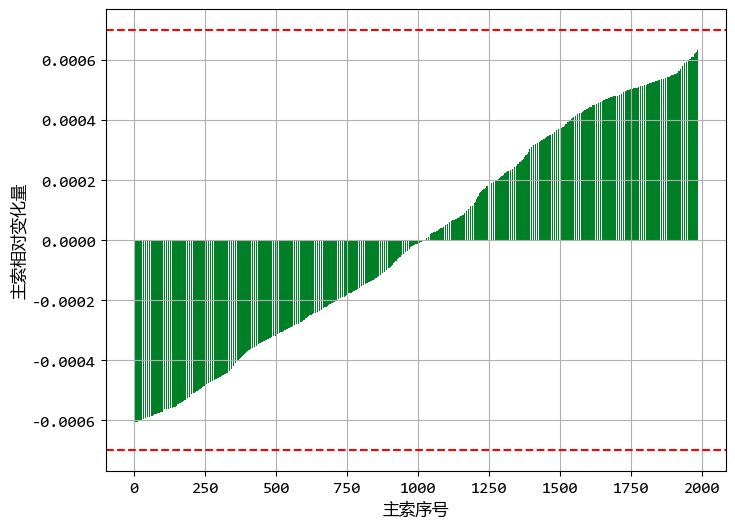

In [30]:
## 第二问：结果读取与输出
# 结果读取
vals = np.loadtxt('./q2result.txt')
wn = np.zeros((Nodenums, 3))
wn[:,0],wn[:,1],wn[:,2] = vals[:Nodenums],vals[Nodenums:2*Nodenums],vals[2*Nodenums:3*Nodenums]
lamb = vals[3*Nodenums:4*Nodenums]

# 绘制伸长量柱状图
plt.figure(figsize=(8, 6))
plt.bar(np.arange(0, Nodenums), sorted(lamb), color='#B41764')
plt.xlabel('促动器序号')
plt.ylabel('伸长量')
plt.grid(True)
plt.savefig('./imgs/q2促动器伸长量.png',dpi=300)

# 绘制各主索节点到理想抛物面距离
idealH = k1 * wn[:,0]**2 + k1 * wn[:,1]**2 + k2
dh = wn[:,2] - idealH
# A = k1 * (wn[:, 0]**2 + wn[:, 1]**2)
# B = 2 * A - wn[:, 2]
# C = A + k2 - wn[:, 2]
# t1 = (-B + np.sqrt(B**2 - 4 * A * C)) / (2 * A)
# t2 = (-B - np.sqrt(B**2 - 4 * A * C)) / (2 * A)
# pn = np.array([
#     wn[:, 0] + wn[:, 0] * t1,
#     wn[:, 1] + wn[:, 1] * t1,
#     wn[:, 2] + wn[:, 2] * t1
# ]).T
# ds = np.where(wn[:, 2] - pn[:, 2] > 0, -1, 1) * np.sqrt((wn[:, 0] - pn[:, 0])**2 + (wn[:, 1] - pn[:, 1])**2 + (wn[:, 2] - pn[:, 2])**2)
plt.figure(figsize=(8, 6))
plt.bar(np.arange(0, Nodenums), sorted(dh), color='#2D3315')
plt.xlabel('主索节点序号')
plt.ylabel('垂直距离')
plt.grid(True)
plt.savefig('./imgs/q2主索节点到理想抛物面的垂直距离.png',dpi=300)

# 绘制俯视图(主索节点相对基态移动距离图)
# 计算相对距离
dh = wn[:,2] - tranWorkingNodes.z.values
cmap = plt.cm.get_cmap('spring')
dh_min = np.min(dh)
dh_max = np.max(dh)
norm = plt.Normalize(vmin=dh_min, vmax=dh_max)
# cmap = plt.cm.get_cmap('spring')
# ds_min = np.min(ds)
# ds_max = np.max(ds)
# norm = plt.Normalize(vmin=ds_min, vmax=ds_max)
plt.figure()
plt.axis('equal')
plt.scatter(tranNodes.iloc[:,1],tranNodes.iloc[:,2], marker = '.',s = 5,color='gray')
plt.scatter(tranWorkingNodes.iloc[:,1], tranWorkingNodes.iloc[:,2], c=dh, cmap=cmap, marker='.', s=20, norm=norm)
cbar = plt.colorbar()
cbar.set_label('相对变化')
plt.savefig('./imgs/q2主索节点相对高度热力图.png',dpi=400)

# 绘制主索相对变化量柱状图
edge_change = []
for key, val in workingEdge_dict.items():
    i, j = key
    curlen = dist((wn[i,0],wn[i,1],wn[i,2]),(wn[j,0],wn[j,1],wn[j,2]))
    edge_change.append((curlen - val) / val)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(0, Edgenums), sorted(edge_change), color='#008026')
plt.axhline(y=-0.0007, color='red', linestyle='dashed')
plt.axhline(y=0.0007, color='red', linestyle='dashed')
plt.xlabel('主索序号')
plt.ylabel('主索相对变化量')
plt.grid(True)
plt.savefig('./imgs/q2主索相对变化量.png',dpi=300)

# 具体数据导出
# 将结果变换回去
inv_wn = np.dot(wn, inv(R.T))
outputDf = pd.DataFrame({'Nodename':tranWorkingNodes.iloc[:, 0].values, 'x':inv_wn[:,0], 'y':inv_wn[:,1], 'z':inv_wn[:,2], 'lamb':lamb})
outputDf.to_excel('q2_result.xlsx',index=False)

In [3]:
### 第三问：数据处理

def calc_circle_center_and_radius(p1, p2, p3):
    # 求空间中三点的外接圆圆心和半径
    x1 = p1[0]
    y1 = p1[1]
    z1 = p1[2]
    x2 = p2[0]
    y2 = p2[1]
    z2 = p2[2]
    x3 = p3[0]
    y3 = p3[1]
    z3 = p3[2]
    a1 = (y1*z2 - y2*z1 - y1*z3 + y3*z1 + y2*z3 - y3*z2)
    b1 = -(x1*z2 - x2*z1 - x1*z3 + x3*z1 + x2*z3 - x3*z2)
    c1 = (x1*y2 - x2*y1 - x1*y3 + x3*y1 + x2*y3 - x3*y2)
    d1 = -(x1*y2*z3 - x1*y3*z2 - x2*y1*z3 + x2*y3*z1 + x3*y1*z2 - x3*y2*z1)
    a2 = 2 * (x2 - x1)
    b2 = 2 * (y2 - y1)
    c2 = 2 * (z2 - z1)
    d2 = x1*x1 + y1*y1 + z1*z1 - x2*x2 - y2*y2 - z2*z2
    a3 = 2 * (x3 - x1)
    b3 = 2 * (y3 - y1)
    c3 = 2 * (z3 - z1)
    d3 = x1*x1 + y1*y1 + z1*z1 - x3*x3 - y3*y3 - z3*z3
    x = -(b1*c2*d3 - b1*c3*d2 - b2*c1*d3 + b2*c3*d1 + b3*c1*d2 - b3*c2*d1) /\
        (a1*b2*c3 - a1*b3*c2 - a2*b1*c3 + a2*b3*c1 + a3*b1*c2 - a3*b2*c1)
    y = (a1*c2*d3 - a1*c3*d2 - a2*c1*d3 + a2*c3*d1 + a3*c1*d2 - a3*c2*d1) /\
        (a1*b2*c3 - a1*b3*c2 - a2*b1*c3 + a2*b3*c1 + a3*b1*c2 - a3*b2*c1)
    z = -(a1*b2*d3 - a1*b3*d2 - a2*b1*d3 + a2*b3*d1 + a3*b1*d2 - a3*b2*d1) /\
        (a1*b2*c3 - a1*b3*c2 - a2*b1*c3 + a2*b3*c1 + a3*b1*c2 - a3*b2*c1)
    r = math.sqrt((x1 - x)*(x1 - x) + (y1 - y)
                       * (y1 - y) + (z1 - z)*(z1 - z))
    return x, y, z, r

## 优化前的做一次
workingReflectorLst = []
# 遍历所有反射镜，求出工作区域内的
for ind, rows in connectInfo.iterrows():
    # 三个节点都是工作节点
    if rows[0] in node_row_dict and rows[1] in node_row_dict and rows[2] in node_row_dict:
        # 获取三点位置
        node1 = list(tranWorkingNodes.loc[node_row_dict[rows[0]],['x','y','z']].values)
        node2 = list(tranWorkingNodes.loc[node_row_dict[rows[1]],['x','y','z']].values)
        node3 = list(tranWorkingNodes.loc[node_row_dict[rows[2]],['x','y','z']].values)
        # 计算平面法向量
        n1n2 = (node1[0] - node2[0],node1[1] - node2[1],node1[2] - node2[2])
        n1n3 = (node1[0] - node3[0],node1[1] - node3[1],node1[2] - node3[2])
        n = np.cross(n1n2, n1n3)
        # 计算n的单位向量
        ne = n / (n[0]**2+n[1]**2+n[2]**2)**0.5
        # 计算球心坐标和半径
        x0, y0, z0, r = calc_circle_center_and_radius(node1,node2,node3)
        
        if (np.array([x0, y0, z0]) + (300.4**2 - r**2)**0.5 * ne)[2] > node1[2]:
            # 圆心的Z值大于三个顶点的Z值
            X0, Y0, Z0 = np.array([x0, y0, z0]) + (300.4**2 - r**2)**0.5 * ne
        else:
            X0, Y0, Z0 = np.array([x0, y0, z0]) - (300.4**2 - r**2)**0.5 * ne

        workingReflectorLst.append({'name':rows[0]+rows[1]+rows[2],
                                    'node1':node1,'node2':node2,'node3':node3,
                                    'nx':ne[0],'ny':ne[1],'nz':ne[2],
                                    'x0':X0,'y0':Y0,'z0':Z0})
        
workingReflector = pd.DataFrame(workingReflectorLst)

## 优化后的
workingReflector_optimed = pd.DataFrame(workingReflectorLst)

# 第二问结果读取
vals = np.loadtxt('./q2result.txt')
wn = np.zeros((Nodenums, 3))
wn[:,0],wn[:,1],wn[:,2] = vals[:Nodenums],vals[Nodenums:2*Nodenums],vals[2*Nodenums:3*Nodenums]

workingReflectorLst_optimed = []
# 遍历所有反射镜，求出工作区域内的
for ind, rows in connectInfo.iterrows():
    # 三个节点都是工作节点
    if rows[0] in node_row_dict and rows[1] in node_row_dict and rows[2] in node_row_dict:
        # 获取三点位置
        node1 = wn[node_row_dict[rows[0]]]
        node2 = wn[node_row_dict[rows[1]]]
        node3 = wn[node_row_dict[rows[2]]]
        # 计算平面法向量
        n1n2 = (node1[0] - node2[0],node1[1] - node2[1],node1[2] - node2[2])
        n1n3 = (node1[0] - node3[0],node1[1] - node3[1],node1[2] - node3[2])
        n = np.cross(n1n2, n1n3)
        # 计算n的单位向量
        ne = n / (n[0]**2+n[1]**2+n[2]**2)**0.5
        # 计算球心坐标和半径
        x0, y0, z0, r = calc_circle_center_and_radius(node1,node2,node3)
        
        if (np.array([x0, y0, z0]) + (300.4**2 - r**2)**0.5 * ne)[2] > node1[2]:
            # 圆心的Z值大于三个顶点的Z值
            X0, Y0, Z0 = np.array([x0, y0, z0]) + (300.4**2 - r**2)**0.5 * ne
        else:
            X0, Y0, Z0 = np.array([x0, y0, z0]) - (300.4**2 - r**2)**0.5 * ne
        
        workingReflectorLst_optimed.append({'name':rows[0]+rows[1]+rows[2],
                                    'node1':node1,'node2':node2,'node3':node3,
                                    'nx':ne[0],'ny':ne[1],'nz':ne[2],
                                    'x0':X0,'y0':Y0,'z0':Z0})

# 优化后的
workingReflector_optimed = pd.DataFrame(workingReflectorLst_optimed)


C:\Users\A-LeiLuo\AppData\Local\Temp\ipykernel_15768\3071160367.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


基态： 0.0551
优化后： 0.6749629343629343


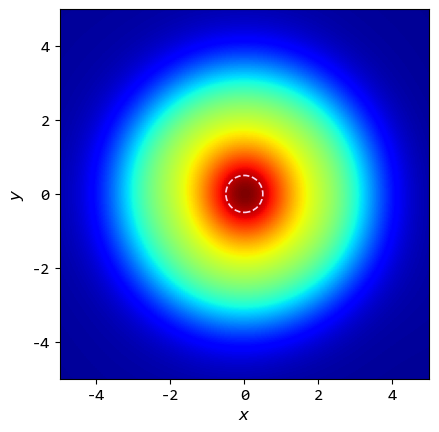

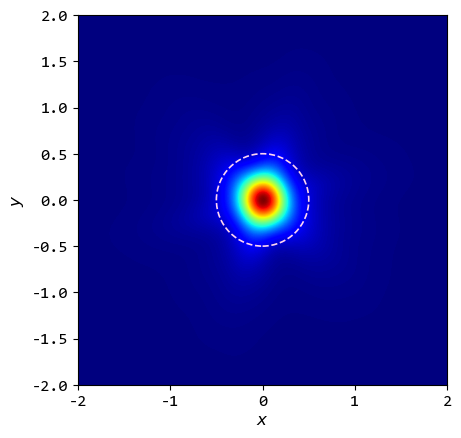

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
from matplotlib.patches import Circle

## 第三问：蒙特卡洛
def myplot(x, y, s=16, bins=800):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

@jit(nopython=True)
def MonteCarlo_Reflector(node1, node2, node3, nx, ny, nz, x0, y0, z0, mc_times):
    # node1,node2,node3：反射镜三个点
    # nx,ny,nz：上述三点组成的法向量
    # p1,p2,p3：球面镜的三个点
    # mc_times：蒙特卡洛次数
    # return：命中次数
    
    R0 = 300.4
    F = 0.466 * R0
    # 馈源舱的高度ze
    ze = -R0 + F
    success_times = 0
    recordPoints_x = []
    recordPoints_y = []
    for i in range(mc_times):
        # 使用重心坐标法在三点间随机取点
        split1 = random.random()
        split2 = random.random()
        split1, split2 = min(split1, split2), max(split1, split2)
        a = split1
        b = split2 - split1
        c = 1 - split2
        #print(a,b,c,a+b+c)
        # 计算随机点
        xt = a * node1[0] + b * node2[0] + c * node3[0]
        yt = a * node1[1] + b * node2[1] + c * node3[1]
        zt = a * node1[2] + b * node2[2] + c * node3[2]
        # 求空间直线与圆的交点
        A = nx**2 + ny**2 + nz**2
        B = 2 * (nx * (xt - x0) + ny * (yt - y0) + nz * (zt - z0))
        C = (xt - x0)**2 + (yt - y0)**2 + (zt - z0)**2 - R0**2
        delta = B**2 - 4 * A * C
        if delta >= 0:
            t1 = (-B + delta**0.5) / (2 * A)
            t2 = (-B - delta**0.5) / (2 * A)
        else:
            print('方程无解')
            return
        
        if abs(t1) > abs(t2):
            t = t2
        else:
            t = t1
        
        xr = xt + nx * t
        yr = yt + ny * t
        zr = zt + nz * t
        
        # 计算投影处圆的法向量b
        vec_b = np.array([(xr - x0) / R0, (yr - y0) / R0, (zr - z0) / R0])
        # 垂直入射向量a
        vec_a = np.array([0, 0, -1])
        # 计算反射向量c
        u = 2 * (vec_a[0] * vec_b[0] + vec_a[1] * vec_b[1] + vec_a[2] * vec_b[2])
        vec_c = np.array([vec_a[0] - u * vec_b[0],
                          vec_a[1] - u * vec_b[1],
                          vec_a[2] - u * vec_b[2]])
        
        # 计算直线在馈源舱的交点(xe, ye, ze)
        xe = xr + (ze - zr) * vec_c[0] / vec_c[2]
        ye = yr + (ze - zr) * vec_c[1] / vec_c[2]
        recordPoints_x.append(xe)
        recordPoints_y.append(ye)
        # 检验是否命中馈源舱
        if xe**2 + ye**2 <= 0.5**2:
            success_times += 1
            
    return success_times, recordPoints_x, recordPoints_y

def q3solve(workingReflector, save_name, xlim=[-2,2], ylim=[-2,2], MC_times=10000,sig = 16):
    # 对于每一行进行10000次蒙特卡洛操作
    recordPoints_x = []
    recordPoints_y = []
    hitSignal = 0
    totSignal = MC_times * workingReflector.shape[0]
    for ind, rows in workingReflector.iterrows():
        ones_hitSignal, ones_recordPoints_x, ones_recordPoints_y = MonteCarlo_Reflector(
                            np.array(rows.node1),np.array(rows.node2),np.array(rows.node3),
                            rows.nx,rows.ny,rows.nz,
                            rows.x0,rows.y0,rows.z0,
                            MC_times)
        hitSignal += ones_hitSignal
        recordPoints_x.extend(ones_recordPoints_x)
        recordPoints_y.extend(ones_recordPoints_y)
        
    if save_name != 'off':
        plt.figure()
        img, extent = myplot(recordPoints_x, recordPoints_y, s=sig)
        plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        # 添加一个半径为0.5的圆
        circle = Circle((0, 0), radius=0.5, edgecolor='#FFD4F0', facecolor='none', linestyle='dashed', linewidth = 1.2)
        plt.gca().add_patch(circle)
        
        plt.savefig(save_name,dpi = 300)
    
    return hitSignal / totSignal

q3baseAns = q3solve(workingReflector, save_name = './imgs/q3基态热力图.png',xlim=[-5,5], ylim=[-5,5], MC_times=2000)
q3optimAns = q3solve(workingReflector_optimed, save_name = './imgs/q3优化后热力图.png', xlim=[-2,2], ylim=[-2,2],MC_times=2000)
print('基态：', q3baseAns)
print('优化后：', q3optimAns)

第1次检验，差值0.0003918918918918157
第2次检验，差值-1.2355212355319445e-05
第3次检验，差值-0.00011081081081087962
第4次检验，差值0.0001667953667953137
第5次检验，差值-5.366795366801291e-05
第6次检验，差值0.00014787644787639387
第7次检验，差值0.00022586872586871642
第8次检验，差值0.00030849420849410336
第9次检验，差值-7.297297297303995e-05
第10次检验，差值0.00017760617760609332
第11次检验，差值0.00029613899613889494
第12次检验，差值0.00014787644787639387
第13次检验，差值-0.00010115830115831059
第14次检验，差值5.173745173736588e-05
第15次检验，差值8.108108108106915e-05
第16次检验，差值0.00012123552123544101
第17次检验，差值0.0003756756756756463
第18次检验，差值0.0002760617760617645
第19次检验，差值-0.0004984555984556271
第20次检验，差值-0.00023706563706571426
第21次检验，差值0.00035019305019301505
第22次检验，差值0.00012586872586861642
第23次检验，差值9.498069498059536e-05
第24次检验，差值-9.38223938224958e-05
第25次检验，差值0.00024749034749027565
第26次检验，差值0.0001722007722007035
第27次检验，差值-5.444015444022732e-05
第28次检验，差值0.0002648648648647667
第29次检验，差值0.00029922779922775256
第30次检验，差值-3.397683397687867e-05
第31次检验，差值0.00021042471042465039
第32次检验，差值0.000153281853

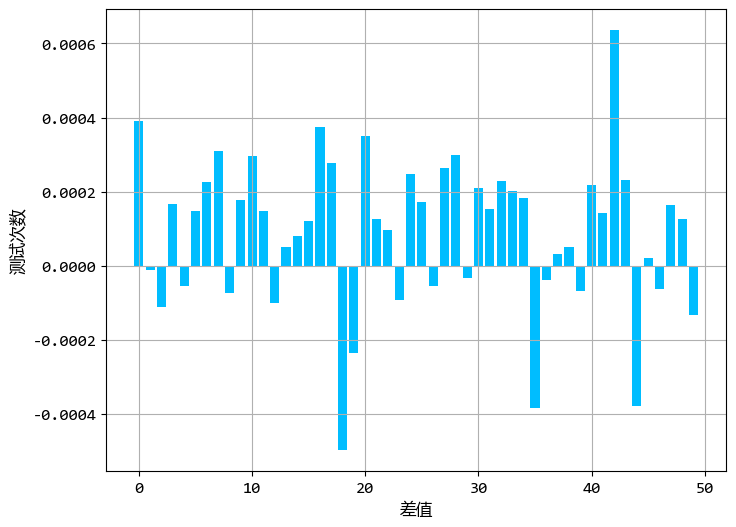

In [28]:
## 蒙特卡洛稳定性检验
valtimes = 50
q3MonteCarloTest = []
for i in range(valtimes):
    q3MonteCarloTest.append(q3optimAns - q3solve(workingReflector_optimed, save_name = 'off', MC_times=2000))
    print(f'第{i+1}次检验，差值{q3MonteCarloTest[-1]}')
    
plt.figure(figsize=(8, 6))
plt.bar(np.arange(0, valtimes), q3MonteCarloTest, color='#00BDFF')
plt.xlabel('测试次数')
plt.ylabel('差值')
plt.grid(True)
plt.savefig('./imgs/q3蒙特卡洛检验.png',dpi=300)
